In [1]:
import pandas as pd
import numpy as np
import os
import gc
import lightgbm as lgb
import sklearn as skl
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib_venn import venn2
import collections as cl
import fastFM as fm
import time
from fastFM import als
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
import scipy.sparse as sp
os.chdir('/home/sambeet/data/AV/am_expert/')

In [2]:
train = pd.read_csv('train_amex/train.csv',parse_dates=['DateTime'],index_col='DateTime').sort_index()
hist_u = pd.read_csv('hist_u.csv')
hist_ut = pd.read_csv('hist_ut.csv')
hist_up = pd.read_csv('hist_up.csv')
hist_pd = pd.read_csv('hist_user_id_product_held.csv')
hist_p = pd.read_csv('hist_p.csv')
test = pd.read_csv('test.csv',parse_dates=['DateTime'],index_col='DateTime').sort_index()

print(train.shape);print(test.shape);#print(historical.shape)
print(train.columns);#print(historical.columns)

print(np.sum(train.isna()))
print(np.sum(test.isna()))
#print(np.sum(historical.isna()))
print(train.describe(include='all'))
#print(test.describe(include='all'))
#print(historical.describe(include='all'))

In [3]:
test['is_click'] = 0
train['train_test'] = 'train'
test['train_test'] = 'test'
col_names = ['session_id','user_id','product_id','campaign_id','webpage_id','product_category_1','product_category_2',
             'user_group_id','gender','age_level','user_depth','city_development_index','var_1','is_click','train_test']
cat_col_names = ['session_id','user_id','product_id','campaign_id','webpage_id','product_category_1',
                 'product_category_2','user_group_id','gender','age_level','user_depth','city_development_index','var_1']
#missing_col_names = ['product_category_2','user_group_id','gender','age_level','user_depth','city_development_index']
train.columns = col_names
test.columns = col_names
train.fillna('NA',inplace=True)
test.fillna('NA',inplace=True)
for col in cat_col_names:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

venn2([set(list(train.session_id)), set(list(test.session_id))],set_labels=['train','test'])
plt.show()

venn2([set(list(train.user_id)), set(list(test.user_id))],set_labels=['train','test'])
plt.show()

venn2([set(list(train.user_id)), set(list(historical.user_id))],set_labels=['train','historical'])
plt.show()

venn2([set(list(test.user_id)), set(list(historical.user_id))],set_labels=['test','historical'])
plt.show()

print train.index.min(),"-",train.index.max() 
#print historical.DateTime.min(),"-",historical.DateTime.max() 
print test.index.min(),"-",test.index.max()

###Train Time Series Visualisation####
click_count = train[['is_click']].resample('H').count()
click_sum = train[['is_click']].resample('H').sum()
click_count['conv_rate'] = 100*click_sum.is_click.astype(np.float32)/click_count.is_click
click_count.plot(subplots=True)

###Train Time Series Visualisation####
click_count = test[['user_id']].resample('H').count()
click_count.plot(subplots=True)

print 'Overall Conversion rate (%):', 100*float(train.is_click.sum())/train.shape[0]
print 'Observations per user (Train):', float(train.shape[0])/len(np.unique(train.user_id))
print 'Clicks per user (Train):', float(train.is_click.sum())/len(np.unique(train.user_id))
print 'Observations per user (Test):', float(test.shape[0])/len(np.unique(test.user_id))

train.groupby('product_id')['is_click'].agg(['mean','count'])

train.groupby(['product_id','campaign_id'])['is_click'].agg(['mean','count'])

train.groupby('webpage_id')['is_click'].agg(['mean','count'])

train.groupby('user_group_id')['is_click'].agg(['mean','count'])

train.groupby('product_category_1')['is_click'].agg(['mean','count'])

train_data.groupby('hour')['is_click'].agg(['mean','count'])

train.groupby('var_1')['is_click'].agg(['mean','count'])

train_data.groupby('dow')['is_click'].agg(['mean','count'])

######Feature Engineering - Concat test and train and then split back######
merged = pd.concat([train,test],axis=0)
def create_features(df,grouped_variable_list):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['minute'] = df.index.minute
#    df['dow'] = df.index.dayofweek
    df['minute'] = df.index.minute
    if len(grouped_variable_list) > 0:
        for group in grouped_variable_list:
            for i in range(len(group)):
                if i == 0:
                    name = group[i]
                else:
                    name = name + '_' + group[i]
            df['cumcount_'+name] = df.groupby(group)['is_click'].cumcount()
#            temp = df.groupby(group)['is_click'].agg(['count']).reset_index().rename({'mean':'mean_encoding_'+name,'count':'count_'+name},axis=1)
#            df = df.merge(temp,on=group,how='left')
    df['cum_clicks_user_id'] = df.groupby('user_id')['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_day'] = df.groupby(['user_id','day'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_product_id'] = df.groupby(['user_id','product_id'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_product_id_day'] = df.groupby(['user_id','product_id','day'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_campaign_id'] = df.groupby(['user_id','campaign_id'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_campaign_id_day'] = df.groupby(['user_id','campaign_id','day'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_product_id'] = df.groupby('product_id')['is_click'].cumsum() - df.is_click
#    df['cum_clicks_product_id_day'] = df.groupby(['product_id','day'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_campaign_id'] = df.groupby('campaign_id')['is_click'].cumsum() - df.is_click
#    df['cum_clicks_campaign_id_day'] = df.groupby(['campaign_id','day'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_product_id_campaign_id'] = df.groupby(['user_id','product_id','campaign_id'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_product_category_1'] = df.groupby('product_category_1')['is_click'].cumsum() - df.is_click
#    df['last_viewed_user'] = df.reset_index()[['user_id','DateTime']].groupby(['user_id']).DateTime.diff().dt.seconds/60
#    df['next_click_user'] = df.reset_index()[['user_id','DateTime']].groupby(['user_id']).DateTime.diff(-1).dt.seconds/60
#    df['cum_clicks_user_id_campaign_id_day_hour'] = df.groupby(['user_id','campaign_id','day','hour'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_product_id_day_hour'] = df.groupby(['product_id','day','hour'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_campaign_id_day_hour'] = df.groupby(['campaign_id','day','hour'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_webpage_id'] = df.groupby('webpage_id')['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_product_id_campaign_id_webpage_id'] = df.groupby(['user_id','product_id','campaign_id','webpage_id'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_product_id_day_hour'] = df.groupby(['user_id','product_id','day','hour'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_hour'] = df.groupby(['user_id','hour'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_day_hour'] = df.groupby(['user_id','day','hour'])['is_click'].cumsum() - df.is_click
#    df['cum_clicks_user_id_day_hour_minute'] = df.groupby(['user_id','day','hour','minute'])['is_click'].cumsum() - df.is_click
    return df
#def elapsed(x):
#    return (x - x.min()).dt.seconds/3600.
#merged['time_since_first_click'] = merged.reset_index().groupby('user_id')['DateTime'].apply(elapsed).values
merged = create_features(merged,[['user_id'],['user_id','day'],['user_id','day','hour'],['user_id','day','hour','minute'],['user_id','campaign_id'],['user_id','campaign_id','product_id'],['user_id','campaign_id','product_id','webpage_id'],['user_id','product_id'],['user_id','webpage_id'],['campaign_id','day'],['campaign_id','day','hour'],['hour','day'],['hour','day','minute']])
merged = merged.merge(historical_features,on=['user_id','product_id'],how='left')
merged['pct_of_user_clicks_up'] = merged.clicks_up.astype(np.float32)/merged.clicks_u
merged['pct_of_product_clicks_up'] = merged.clicks_up.astype(np.float32)/merged.clicks_p
merged = merged.sort_index()
#merged['temp_col'] = merged['train_test'].apply(lambda x: 1 if x == 'train' else 0)
#cum_count = merged['temp_col'].cumsum()
#cum_clicks = merged['is_click'].cumsum()
#merged['rolling_ctr'] = cum_clicks.astype(np.float32)/cum_count
merged['avg_clicks_per_day_active_user'] = merged.clicks_u.astype(np.float32)/merged.days_active
merged['avg_clicks_per_day_active_user_product'] = merged.clicks_up.astype(np.float32)/merged.days_active
merged['pct_days_active'] = merged.unique_days_active.astype(np.float32)/merged.days_active
#merged.drop(['temp_col'],axis=1,inplace=True)

In [46]:
######Feature Engineering - Concat test and train and then split back######
merged = pd.concat([train,test],axis=0)
def create_features(df,grouped_variable_list):
    df = df.sort_index()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['minute'] = df.index.minute
#    df['last_viewed_user'] = df.reset_index()[['user_id','DateTime']].groupby(['user_id']).DateTime.diff().dt.seconds/60
#    df['next_click_user'] = df.reset_index()[['user_id','DateTime']].groupby(['user_id']).DateTime.diff(-1).dt.seconds/60
    if len(grouped_variable_list) > 0:
        for group in grouped_variable_list:
            for i in range(len(group)):
                if i == 0:
                    name = group[i]
                else:
                    name = name + '_' + group[i]
            df['cumcount_'+name] = df.groupby(group)['is_click'].cumcount()
#            temp = df.groupby(group)['is_click'].agg(['count']).reset_index().rename({'mean':'mean_encoding_'+name,'count':'count_'+name},axis=1)
#            df = df.merge(temp,on=group,how='left')
    df['cum_clicks_user_id'] = df.groupby('user_id')['is_click'].cumsum() - df.is_click
    return df
def elapsed(x):
    return (x - x.min()).dt.seconds/3600.
#merged['time_since_first_click'] = merged.reset_index().groupby('user_id')['DateTime'].apply(elapsed).values
merged = create_features(merged,[['user_id'],['user_id','day'],['user_id','day','hour'],['user_id','day','hour','minute'],['user_id','campaign_id'],['user_id','campaign_id','product_id'],['user_id','campaign_id','product_id','webpage_id'],['user_id','product_id'],['user_id','webpage_id'],['campaign_id','day'],['campaign_id','day','hour'],['hour','day'],['hour','day','minute']])
merged = merged.merge(hist_up,on=['user_id','product_id'],how='left')
merged = merged.merge(hist_u,on=['user_id'],how='left')
merged = merged.merge(hist_ut,on=['user_id'],how='left')
merged = merged.merge(hist_pd,on=['user_id'],how='left')
merged = merged.merge(hist_p,on=['product_id'],how='left')
merged['pct_of_user_clicks_up'] = merged.clicks_up.astype(np.float32)/merged.clicks_u
merged['pct_of_product_clicks_up'] = merged.clicks_up.astype(np.float32)/merged.clicks_p
merged['avg_clicks_per_day_active_user'] = merged.clicks_u.astype(np.float32)/merged.days_active
merged['avg_clicks_per_day_active_user_product'] = merged.clicks_up.astype(np.float32)/merged.days_active
merged['pct_days_active'] = merged.unique_days_active.astype(np.float32)/merged.days_active
merged['new_user_ind'] = merged.days_active.isna().astype(int)
missing_cols_float = ['pct_interest_up','pct_view_up','clicks_up','pct_interest_u','pct_view_u','clicks_u','days_active',
               'unique_days_active','A','B','C','D','E','F','G','H','I','J','pct_of_user_clicks_up','pct_of_product_clicks_up',
                     'avg_clicks_per_day_active_user','avg_clicks_per_day_active_user_product','pct_days_active']
for col in missing_cols_float:
    merged[col].fillna(0,inplace=True)
merged['total_product_held'] = merged['A'] + merged['B'] + merged['C'] + merged['D'] + merged['E'] + merged['F'] + merged['G'] + merged['H'] + merged['I'] + merged['J']

In [47]:
predictors = list(merged.columns.values)
predictors.remove('train_test')
predictors.remove('is_click')
predictors.remove('session_id')
categorical = cat_col_names + ['hour']
categorical.remove('session_id')
target = 'is_click'
for col in categorical:
    print 'Transforming {}...'.format(col)
    encoder = LabelEncoder()
    encoder.fit(merged[col])
    merged[col] = encoder.transform(merged[col])
train_data = merged.loc[merged.train_test == 'train']
train_data.reset_index(inplace=True,drop=True)
test_data = merged.loc[merged.train_test == 'test']
test_data.reset_index(inplace=True,drop=True)

Transforming user_id...
Transforming product_id...
Transforming campaign_id...
Transforming webpage_id...
Transforming product_category_1...
Transforming product_category_2...
Transforming user_group_id...
Transforming gender...
Transforming age_level...
Transforming user_depth...
Transforming city_development_index...
Transforming var_1...
Transforming hour...


In [48]:
predictors_fm = ['user_id','product_id','campaign_id','webpage_id','product_category_1','user_group_id','gender',
                 'age_level','user_depth','var_1']
categorical_indices = np.array([True for col in predictors_fm])
encoder = OneHotEncoder(categorical_features=categorical_indices,dtype=np.int8,sparse=True)
encoder.fit(merged[predictors_fm])
x = encoder.transform(train_data[predictors_fm])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(x, train_data[target])
y_train = y_train.astype(int).values
y_test = y_test.astype(int).values
y_train[y_train == 0] = -1

n_iter = 50
step_size = 1
start = time.time()
auc_train = []
auc_test = []
z = als.FMClassification(n_iter=0, l2_reg_w=25, l2_reg_V=300, rank=16)
z.fit(X_train, y_train)
for i in range(n_iter):
    print 'Training Iteration #',i+1
    z.fit(X_train, y_train, n_more_iter=step_size)
    train_auc = roc_auc_score(y_train,z.predict_proba(X_train))
    test_auc = roc_auc_score(y_test,z.predict_proba(X_test))
    auc_train.append(train_auc)
    auc_test.append(test_auc)
    print 'Train AUC:',train_auc,'Test AUC:',test_auc
end = time.time()
print (end - start)/60, ' minutes'

from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=1, figsize=(15, 10))
x = np.arange(1, n_iter+1) * step_size
with plt.style.context('fivethirtyeight'):
    axes.plot(x, auc_train, label='AUC-train', color='r', ls="--")
    axes.plot(x, auc_test, label='AUC-test', color='r')
axes.set_ylabel('AUC', color='r')
axes.legend()

In [50]:
num_folds = 5
kf = KFold(n_splits=num_folds,shuffle=True,random_state=37)
kf.get_n_splits(train_data)
test_submit = encoder.transform(test_data[predictors_fm])
train_data['pred_fm'] = 0
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train_data)):
    X_train = train_data.loc[train_index,predictors_fm]
    X_test = train_data.loc[test_index,predictors_fm]
    y_train = train_data.loc[train_index,target]
    y_test = train_data.loc[test_index,target]
    y_train = y_train.astype(int).values.squeeze()
    y_test = y_test.astype(int).values.squeeze()
    y_train[y_train == 0] = -1
    X_train = encoder.transform(X_train)
    X_test = encoder.transform(X_test)
    print 'Starting training on new fold!'
    z = als.FMClassification(l2_reg_w=25, l2_reg_V=300, rank=16, n_iter=25)
    z.fit(X_train,y_train)
    y_pred_train = z.predict_proba(X_train)
    y_pred_test = z.predict_proba(X_test)
    test_data['pred_fm_' + str(i)] = z.predict_proba(test_submit)
    train_data['pred_fm'][test_index] = y_pred_test
    print 'Train AUC: ',roc_auc_score(y_train,y_pred_train)
    print 'Test AUC: ',roc_auc_score(y_test,y_pred_test)

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Starting training on new fold!


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train AUC:  0.9137085421956502
Test AUC:  0.6245801070367746
Starting training on new fold!
Train AUC:  0.9147242747768627
Test AUC:  0.6192893500020227
Starting training on new fold!
Train AUC:  0.9146430152150661
Test AUC:  0.6160559550169487
Starting training on new fold!
Train AUC:  0.9145585382948882
Test AUC:  0.6184431034727369
Starting training on new fold!
Train AUC:  0.913914778403961
Test AUC:  0.6153270060294047


In [51]:
test_data['pred_fm'] = 0
for i in range(1,num_folds+1):
    test_data['pred_fm'] = test_data['pred_fm'] + test_data['pred_fm_'+str(i)]
test_data['pred_fm'] = test_data['pred_fm']/float(num_folds)
test_data.drop(['pred_fm_1','pred_fm_2','pred_fm_3','pred_fm_4','pred_fm_5'],inplace=True,axis=1)
predictors.append('pred_fm')

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [73]:
rounds = 5000
early_stop_rounds = 100
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 255,
    'max_depth': 12,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.5,
#    'bagging_fraction' : 0.8,
#    'bagging_freq' : 20,
    'verbosity' : 0,
    'num_threads' : 8,
    'min_data_in_leaf' : 10,
    'lambda_l1' : 0.1,
    'lambda_l2' : 0.1,
#    'cat_smooth' : 5,
    'max_bin' : 25,
#    'min_gain_to_split' : 0.5,
    'max_cat_to_onehot' : 50,
    'scale_pos_weight' : 1
}

num_folds = 5

In [74]:
kf = KFold(n_splits=num_folds,shuffle=True,random_state=37)
kf.get_n_splits(train_data)
results_train = []
results_valid = []
feature_importance = dict()
train_data['pred_target_lgb1'] = 0
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train_data)):
    X_train = train_data.loc[train_index,predictors].values
    X_test = train_data.loc[test_index,predictors].values
    y_train = train_data.loc[train_index,target].values
    y_test = train_data.loc[test_index,target].values
    X_train = lgb.Dataset(X_train,y_train,feature_name=predictors,categorical_feature = categorical)
    X_test = lgb.Dataset(X_test,y_test,feature_name=predictors,categorical_feature = categorical)
    gc.collect()
    print 'Starting training on fold:',i
    model = lgb.train(lgbm_params,X_train,num_boost_round=rounds,valid_sets=[X_train,X_test],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=1000)
    results_train.append(model.best_score['train']['auc'])
    results_valid.append(model.best_score['valid']['auc'])
    test_data['target_lgb1_' + str(i)] = model.predict(test_data.loc[:,predictors].values)
    train_data['pred_target_lgb1'][test_index] = model.predict(train_data.loc[test_index,predictors].values)
    total_gain = np.sum(model.feature_importance('gain'))
    if i == 1:
        for feature, importance in zip(model.feature_name(),model.feature_importance('gain')):
            feature_importance.update({feature : importance/total_gain})
    else:
        for feature, importance in zip(model.feature_name(),model.feature_importance('gain')):
            feature_importance[feature] = feature_importance[feature] + (importance/total_gain)
for feature,importance in zip(feature_importance.keys(),feature_importance.values()):
    feature_importance[feature] = 100*importance/num_folds
feature_importance = cl.OrderedDict(sorted(feature_importance.items(), key=lambda t: t[1], reverse=True))
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Starting training on fold: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[369]	train's auc: 0.765446	valid's auc: 0.653939


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Starting training on fold: 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[499]	train's auc: 0.798393	valid's auc: 0.646112
Starting training on fold: 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[546]	train's auc: 0.806997	valid's auc: 0.645013
Starting training on fold: 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[383]	train's auc: 0.770882	valid's auc: 0.647738
Starting training on fold: 5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[495]	train's auc: 0.794145	valid's auc: 0.647674
Train:0.7871725315902515+-0.016155125678150212 Valid:0.6480952030846452+-0.003094611677757342


In [75]:
kf = KFold(n_splits=num_folds,shuffle=True,random_state=57)
kf.get_n_splits(train_data)
results_train = []
results_valid = []
feature_importance = dict()
train_data['pred_target_lgb2'] = 0
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train_data)):
    X_train = train_data.loc[train_index,predictors].values
    X_test = train_data.loc[test_index,predictors].values
    y_train = train_data.loc[train_index,target].values
    y_test = train_data.loc[test_index,target].values
    X_train = lgb.Dataset(X_train,y_train,feature_name=predictors,categorical_feature = categorical)
    X_test = lgb.Dataset(X_test,y_test,feature_name=predictors,categorical_feature = categorical)
    gc.collect()
    print 'Starting training on fold:',i
    model = lgb.train(lgbm_params,X_train,num_boost_round=rounds,valid_sets=[X_train,X_test],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=1000)
    results_train.append(model.best_score['train']['auc'])
    results_valid.append(model.best_score['valid']['auc'])
    test_data['target_lgb2_' + str(i)] = model.predict(test_data.loc[:,predictors].values)
    train_data['pred_target_lgb2'][test_index] = model.predict(train_data.loc[test_index,predictors].values)
    total_gain = np.sum(model.feature_importance('gain'))
    if i == 1:
        for feature, importance in zip(model.feature_name(),model.feature_importance('gain')):
            feature_importance.update({feature : importance/total_gain})
    else:
        for feature, importance in zip(model.feature_name(),model.feature_importance('gain')):
            feature_importance[feature] = feature_importance[feature] + (importance/total_gain)
for feature,importance in zip(feature_importance.keys(),feature_importance.values()):
    feature_importance[feature] = 100*importance/num_folds
feature_importance = cl.OrderedDict(sorted(feature_importance.items(), key=lambda t: t[1], reverse=True))
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Starting training on fold: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[581]	train's auc: 0.811902	valid's auc: 0.652345


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Starting training on fold: 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[490]	train's auc: 0.795756	valid's auc: 0.646072
Starting training on fold: 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[513]	train's auc: 0.800291	valid's auc: 0.648027
Starting training on fold: 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[499]	train's auc: 0.798397	valid's auc: 0.644883
Starting training on fold: 5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[506]	train's auc: 0.797919	valid's auc: 0.648833
Train:0.8008528488356503+-0.005710051423407418 Valid:0.6480320465069822+-0.0025690523346369514


In [76]:
kf = KFold(n_splits=num_folds,shuffle=True,random_state=124)
kf.get_n_splits(train_data)
results_train = []
results_valid = []
feature_importance = dict()
train_data['pred_target_lgb3'] = 0
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train_data)):
    X_train = train_data.loc[train_index,predictors].values
    X_test = train_data.loc[test_index,predictors].values
    y_train = train_data.loc[train_index,target].values
    y_test = train_data.loc[test_index,target].values
    X_train = lgb.Dataset(X_train,y_train,feature_name=predictors,categorical_feature = categorical)
    X_test = lgb.Dataset(X_test,y_test,feature_name=predictors,categorical_feature = categorical)
    gc.collect()
    print 'Starting training on fold:',i
    model = lgb.train(lgbm_params,X_train,num_boost_round=rounds,valid_sets=[X_train,X_test],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=1000)
    results_train.append(model.best_score['train']['auc'])
    results_valid.append(model.best_score['valid']['auc'])
    test_data['target_lgb3_' + str(i)] = model.predict(test_data.loc[:,predictors].values)
    train_data['pred_target_lgb3'][test_index] = model.predict(train_data.loc[test_index,predictors].values)
    total_gain = np.sum(model.feature_importance('gain'))
    if i == 1:
        for feature, importance in zip(model.feature_name(),model.feature_importance('gain')):
            feature_importance.update({feature : importance/total_gain})
    else:
        for feature, importance in zip(model.feature_name(),model.feature_importance('gain')):
            feature_importance[feature] = feature_importance[feature] + (importance/total_gain)
for feature,importance in zip(feature_importance.keys(),feature_importance.values()):
    feature_importance[feature] = 100*importance/num_folds
feature_importance = cl.OrderedDict(sorted(feature_importance.items(), key=lambda t: t[1], reverse=True))
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Starting training on fold: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[528]	train's auc: 0.804048	valid's auc: 0.646391


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Starting training on fold: 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[375]	train's auc: 0.768329	valid's auc: 0.646991
Starting training on fold: 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[476]	train's auc: 0.792599	valid's auc: 0.649984
Starting training on fold: 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[367]	train's auc: 0.76591	valid's auc: 0.647133
Starting training on fold: 5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[546]	train's auc: 0.80395	valid's auc: 0.649378
Train:0.7869671003487352+-0.016749235037826094 Valid:0.6479755271332953+-0.0014276834220829644


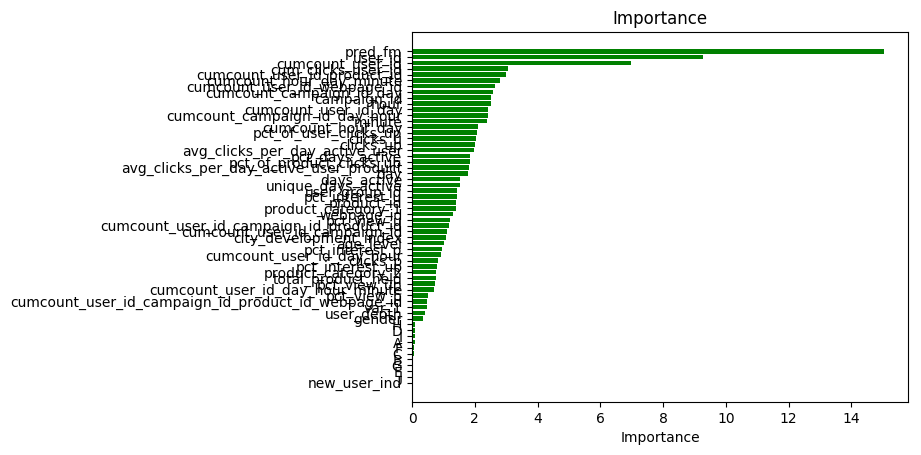

In [77]:
plt.rcdefaults()
fig, ax = plt.subplots()
# Example data
y_pos = np.arange(len(feature_importance.keys()))
ax.barh(y_pos, feature_importance.values(),  align='center',color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importance.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Importance')
plt.show()

In [78]:
import catboost as cb
from sklearn.metrics import roc_auc_score
cat_features_index = []
for cat in categorical:
    for pred in predictors:
        if cat == pred:
            cat_features_index.append(predictors.index(cat))
kf = KFold(n_splits=num_folds,shuffle=True,random_state=42)
kf.get_n_splits(train_data)
results_train = []
results_valid = []
train_data['pred_target_cb1'] = 0
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train_data)):
    X_train = train_data.loc[train_index,predictors].values
    X_test = train_data.loc[test_index,predictors].values
    y_train = train_data.loc[train_index,target].values
    y_test = train_data.loc[test_index,target].values
    gc.collect()
    print 'Starting training on fold:',i
    model = cb.CatBoostClassifier(eval_metric="AUC",depth=10,iterations=100,l2_leaf_reg=0.2,learning_rate=0.01)
    model.fit(X_train,y_train, cat_features= cat_features_index,eval_set=(X_test,y_test),verbose=25)
    results_train.append(roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))
    results_valid.append(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
    train_data['pred_target_cb1'][test_index] = model.predict_proba(X_test)[:,1]
    test_data['target_cb1_' + str(i)] = model.predict_proba(test_data.loc[:,predictors].values)[:,1]
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Starting training on fold: 1
0:	learn: 0.6401291	test: 0.6295134	best: 0.6295134 (0)	total: 992ms	remaining: 1m 38s
25:	learn: 0.6597104	test: 0.6380422	best: 0.6380422 (25)	total: 26s	remaining: 1m 14s
50:	learn: 0.6619526	test: 0.6369505	best: 0.6383455 (38)	total: 50.7s	remaining: 48.7s
75:	learn: 0.6646099	test: 0.6367279	best: 0.6383455 (38)	total: 1m 15s	remaining: 24s

bestTest = 0.6383454985
bestIteration = 38

Shrink model to first 39 iterations.


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Starting training on fold: 2
0:	learn: 0.6396419	test: 0.6291478	best: 0.6291478 (0)	total: 1.02s	remaining: 1m 40s
25:	learn: 0.6590319	test: 0.6418022	best: 0.6420642 (24)	total: 26.6s	remaining: 1m 15s
50:	learn: 0.6624685	test: 0.6403586	best: 0.6420809 (27)	total: 51s	remaining: 49s
75:	learn: 0.6645469	test: 0.6395898	best: 0.6420809 (27)	total: 1m 15s	remaining: 23.8s

bestTest = 0.6420808892
bestIteration = 27

Shrink model to first 28 iterations.
Starting training on fold: 3
0:	learn: 0.6417587	test: 0.6312237	best: 0.6312237 (0)	total: 980ms	remaining: 1m 37s
25:	learn: 0.6579289	test: 0.6410469	best: 0.6413175 (24)	total: 26.9s	remaining: 1m 16s
50:	learn: 0.6613986	test: 0.6407194	best: 0.6414501 (27)	total: 52.6s	remaining: 50.6s
75:	learn: 0.6635460	test: 0.6400774	best: 0.6414501 (27)	total: 1m 17s	remaining: 24.5s

bestTest = 0.6414500704
bestIteration = 27

Shrink model to first 28 iterations.
Starting training on fold: 4
0:	learn: 0.6386196	test: 0.6223145	best: 0.622

In [79]:
import catboost as cb
from sklearn.metrics import roc_auc_score
cat_features_index = []
for cat in categorical:
    for pred in predictors:
        if cat == pred:
            cat_features_index.append(predictors.index(cat))
kf = KFold(n_splits=num_folds,shuffle=True,random_state=12)
kf.get_n_splits(train_data)
results_train = []
results_valid = []
train_data['pred_target_cb2'] = 0
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train_data)):
    X_train = train_data.loc[train_index,predictors].values
    X_test = train_data.loc[test_index,predictors].values
    y_train = train_data.loc[train_index,target].values
    y_test = train_data.loc[test_index,target].values
    gc.collect()
    print 'Starting training on fold:',i
    model = cb.CatBoostClassifier(eval_metric="AUC",depth=10,iterations=50,l2_leaf_reg=0.2,learning_rate=0.01)
    model.fit(X_train,y_train, cat_features= cat_features_index,eval_set=(X_test,y_test),verbose=25)
    results_train.append(roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))
    results_valid.append(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
    train_data['pred_target_cb2'][test_index] = model.predict_proba(X_test)[:,1]
    test_data['target_cb2_' + str(i)] = model.predict_proba(test_data.loc[:,predictors].values)[:,1]
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Starting training on fold: 1
0:	learn: 0.6413545	test: 0.6280457	best: 0.6280457 (0)	total: 1.02s	remaining: 50s
25:	learn: 0.6580747	test: 0.6407359	best: 0.6407779 (24)	total: 25.2s	remaining: 23.3s

bestTest = 0.6412752435
bestIteration = 38

Shrink model to first 39 iterations.


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Starting training on fold: 2
0:	learn: 0.6397313	test: 0.6333093	best: 0.6333093 (0)	total: 956ms	remaining: 46.9s
25:	learn: 0.6567771	test: 0.6409626	best: 0.6409626 (25)	total: 25.2s	remaining: 23.2s

bestTest = 0.6411572994
bestIteration = 27

Shrink model to first 28 iterations.
Starting training on fold: 3
0:	learn: 0.6405288	test: 0.6265678	best: 0.6265678 (0)	total: 979ms	remaining: 48s
25:	learn: 0.6582042	test: 0.6368053	best: 0.6369312 (24)	total: 27.3s	remaining: 25.2s

bestTest = 0.6370552427
bestIteration = 35

Shrink model to first 36 iterations.
Starting training on fold: 4
0:	learn: 0.6417650	test: 0.6294648	best: 0.6294648 (0)	total: 1.09s	remaining: 53.4s
25:	learn: 0.6582073	test: 0.6431872	best: 0.6432627 (22)	total: 27.2s	remaining: 25.1s

bestTest = 0.6433662839
bestIteration = 26

Shrink model to first 27 iterations.
Starting training on fold: 5
0:	learn: 0.6393177	test: 0.6239329	best: 0.6239329 (0)	total: 1.09s	remaining: 53.4s
25:	learn: 0.6588796	test: 0.637

In [80]:
test_data['pred_target_lgb1'] = 0.
test_data['pred_target_lgb2'] = 0.
test_data['pred_target_lgb3'] = 0.
test_data['pred_target_cb1'] = 0.
test_data['pred_target_cb2'] = 0.
for i in range(1,num_folds+1):
    test_data['pred_target_lgb1'] = test_data['pred_target_lgb1'] + test_data['target_lgb1_'+str(i)]
    test_data['pred_target_lgb2'] = test_data['pred_target_lgb2'] + test_data['target_lgb2_'+str(i)]
    test_data['pred_target_lgb3'] = test_data['pred_target_lgb3'] + test_data['target_lgb3_'+str(i)]
    test_data['pred_target_cb1'] = test_data['pred_target_cb1'] + test_data['target_cb1_'+str(i)]
    test_data['pred_target_cb2'] = test_data['pred_target_cb2'] + test_data['target_cb2_'+str(i)]
test_data['pred_target_lgb1'] = test_data['pred_target_lgb1']/float(num_folds)
test_data['pred_target_lgb2'] = test_data['pred_target_lgb2']/float(num_folds)
test_data['pred_target_lgb3'] = test_data['pred_target_lgb3']/float(num_folds)
test_data['pred_target_cb1'] = test_data['pred_target_cb1']/float(num_folds)
test_data['pred_target_cb2'] = test_data['pred_target_cb2']/float(num_folds)

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [142]:
from sklearn.linear_model import LogisticRegression
stacking_columns = ['pred_target_lgb1','pred_target_lgb2','pred_target_lgb3','pred_target_cb1','pred_target_cb2']
train_data2 = train_data[stacking_columns]
test_data2 = test_data[['session_id'] + stacking_columns]
for col in stacking_columns:
    train_data2[col] = train_data2[col].rank(pct=True)
    test_data2[col] = test_data2[col].rank(pct=True)
lr_model=LogisticRegression()
lr_model.fit(X=train_data2[stacking_columns].values,y=train_data[target].values)
print(roc_auc_score(y_score=lr_model.predict_proba(train_data2[stacking_columns].values)[:,1],y_true=train_data[target].values))
test_data2['is_click']=lr_model.predict_proba(X=test_data2[stacking_columns])[:,1]
test_data2[['session_id','is_click']].to_csv('sub_sam_stack_lr.csv',index=False)

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0.6490448377769633


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
